# Hello World of Predict Store Sales

This example is near replication of sample code published by DataBriefing for Kaggle Rossmann Store Sales competition. 

[Kaggle.com Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales/).

[Original DataBriefing Code](https://github.com/databriefing/article-notebooks/tree/master/rossmann).
[https://github.com/databriefing/article-notebooks/tree/master/rossmann](https://github.com/databriefing/article-notebooks/tree/master/rossmann).



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./data/train.csv')

C:\Dev\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# Generates descriptive statistics that summarize the central tendency,
#  dispersion and shape of a dataset’s distribution, excluding NaN values.
data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [5]:
# Print data types of the columns
data.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [6]:
# To list all different values of the StateHoliday column values
data.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [7]:
# We see that StateHoliday is no binary feature (0 or 1) it's not even a numeric feature.
# This is a problem for most algorithms and so we'll have to fix this later on by creating dummy variables.
# First let's fix an obvious mistake in the dataset: StateHoliday has both 0 as an integer and a string.
# So let's convert this whole column to string values.
data.StateHoliday = data.StateHoliday.astype(str)

In [8]:
data.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [9]:
# List the number of unique values for each colum
# Apply the function to each column (axis=0)

def count_unique(column):
    return len(column.unique())

data.apply(count_unique, axis=0).astype(np.int32)

# We define a function and apply this function to each column (i.e. along axis 0)
# This tells us a few interesting things.
# Apparently there are over a thousand different stores and we have data for 942 different days.
# Some features are binary and StateHoliday - as we've already seen - has 4 different values.
# DayOfWeek unsurprisingly has 7 different values.

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int32

In [10]:
# Check for missing values
# Missing values - most obvious when we have null values in
# the dataset - are a huge problem and we'll focus on missing values in a future article.
# Let's check if our dataset has any null values:
data.isnull().any()

Store            False
DayOfWeek        False
Date             False
Sales            False
Customers        False
Open             False
Promo            False
StateHoliday     False
SchoolHoliday    False
dtype: bool

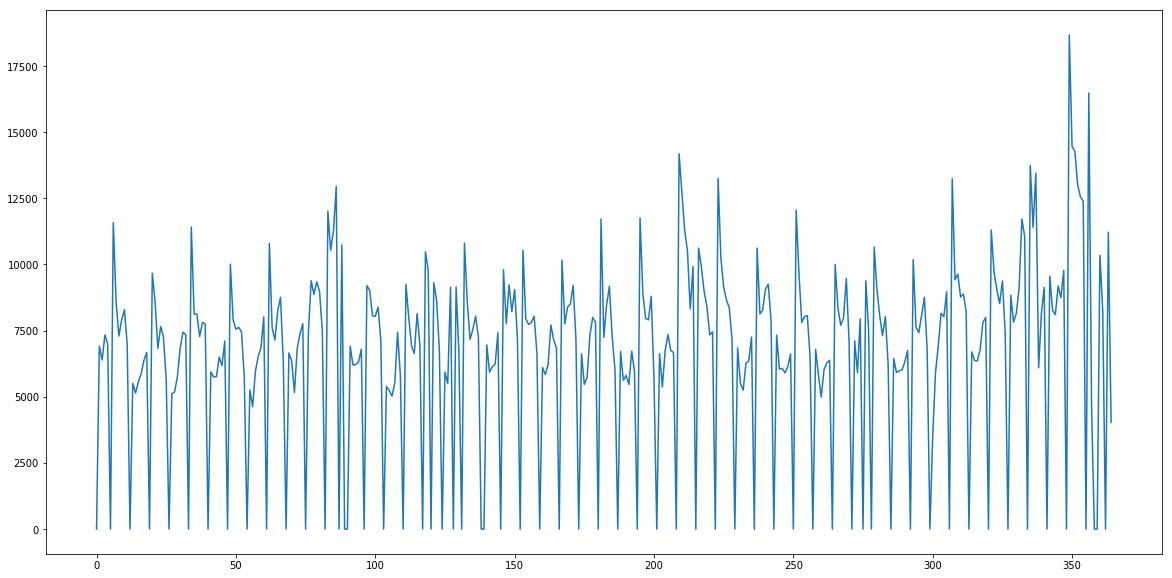

In [11]:
# visualize store 150 sale data
# Now would be a good moment to visualize some data. Just for intuition.
# The following code takes sales numbers for a specific store - store 150 -
# and plots the first 365 days sorted by Date.

# Filter data for store 150 and plot sales data for first 365 days
store_data = data[data.Store==150].sort_values('Date')
plt.figure(figsize=(20, 10))  # Set figsize to increase size of figure
plt.plot(store_data.Sales.values[:365])

C:\Dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Text(0,0.5,'Sales')

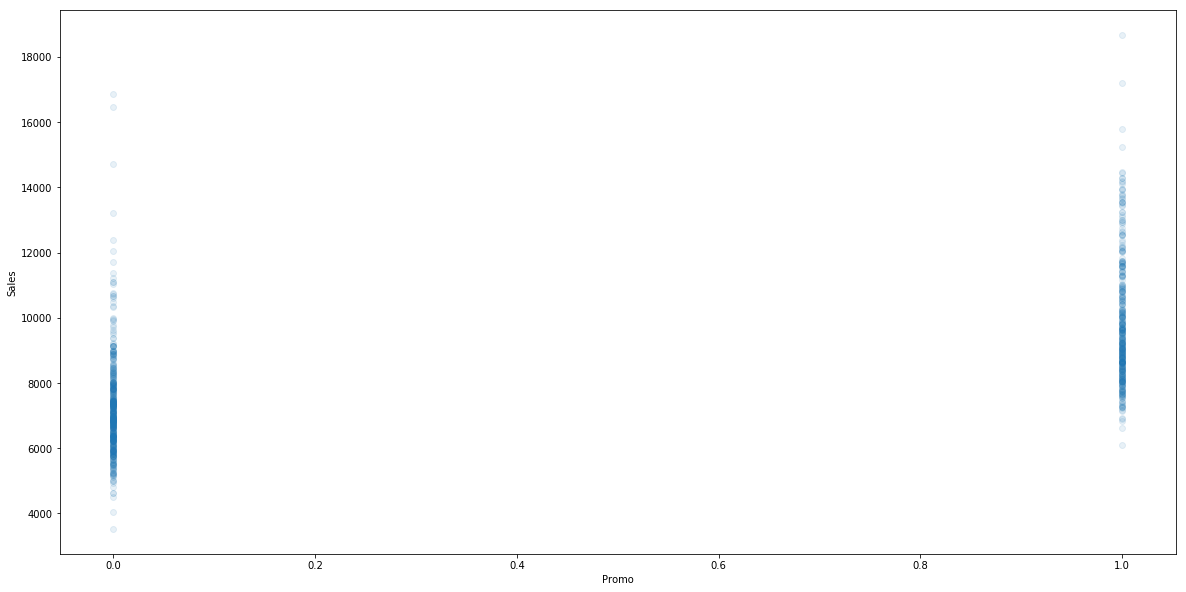

In [12]:
# We can clearly see that this store is closed on Sundays.
# But there's also an interesting pattern: Every second week or so sales increase.
# Maybe we can find out why. Create a new cell, just input store_data and run the cell.
# This will display the first rows of our store_data variable that holds all sales of store 150.
# A feature that looks like it could correspond to that weekly period is Promo.

# A great way to get an intuition for correlations is a scatter plot:
plt.figure(figsize=(20, 10))
plt.scatter(x=store_data[data.Open==1].Promo, y=store_data[data.Open==1].Sales, alpha=0.1)
plt.xlabel('Promo')
plt.ylabel('Sales')

In [13]:
# Apparently sales are higher when they run a promo on the same day, which makes sense.
# (To really, scientifically say something about the data we
# would have to do some further analysis and statistical tests.
# But we only want an intuition and try out some ways to visualize data so this will do for now.)
# Now that we have a basic understanding of our dataset we can start to prepare it for prediction algorithms.

## Transformations

In [14]:
# Transforming Data by Dropping features
# Let's think about the goal of our predictions:
# We want to predict sales numbers for a specific day and store with a set of features that we know beforehand.
# For example if we'll run a promo or what day of the week it will be.
# We have a lot of features like these that should help the algorithm predict sales numbers.
# But we also have three features in our data that don't make sense at this stage and so we'll drop them:

#### Store:
# The store number doesn't in itself predict sales. E.g. a higher store number says nothing about the sales.

#### Date:
# We could transform the date into something like days since first sale to catch a possible continuous sales growth but we don't do that now.

#### Customers:
# This column won't help us at all. As you can see in test.csv we won't have this feature later to make predictions.
# Which is obvious as you don't know the number of customers on a given day in the future.
# This would be a feature we could learn and predict just like sales numbers.

transformed_data = data.drop(['Store', 'Date', 'Customers'], axis=1)

In [15]:
transformed_data.head()

,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,5,5263,1,1,0,1
1,5,6064,1,1,0,1
2,5,8314,1,1,0,1
3,5,13995,1,1,0,1
4,5,4822,1,1,0,1


In [16]:
### Categorical and Nominal Features
# Let's look at StateHoliday again. In our dataset it has four unique values.
# All of them strings: '0', 'a', 'b', 'c'.
# To use this feature to train our algorithm we have to transform it into numerical values.
# So could we instead just use 0, 1, 2, 3?
# Not in this case and not in the case of DayOfWeek.
# Like Store there is no intrinsic order, ranking or value in StateHoliday and
# simply using numbers here would only confuse the algorithm

# This replaces the feature with a binary feature for each value.
# So for StateHoliday which can have the values 0, a, b or c it will replace
# StateHoliday with StateHoliday_0, StateHoliday_a, StateHoliday_b and StateHoliday_c.
# And for a row who's StateHoliday was b it would set StateHoliday_b = 1 and the other StateHoliday_ features = 0.
# This technique is also called one-hot encoding
# (because only the feature representing the value will be 1 - i.e. 'hot' - and the rest will be 0).

transformed_data = pd.get_dummies(transformed_data, columns=['DayOfWeek', 'StateHoliday'])

In [17]:
# First we separate our dataset into the values we want to predict (Sales) and
# the values to train the algorithm with (all our features like Promo, DayOfWeek_x, etc).
X = transformed_data.drop(['Sales'], axis=1).values
y = transformed_data.Sales.values

# X is the matrix that contains all data from which we want to be able to predict sales data.
# So before assigning the values of transformed_data to X we drop the Sales column.
# .values finally gives us a matrix of raw values that we can feed to the algorithm.
# y contains only the sales numbers.

# The print statement shows us that X is a 1017209 by 14 matrix (14 features and 1017209 training examples).
print("The training dataset has {} examples and {} features.".format(X.shape[0], X.shape[1]))

The training dataset has 1017209 examples and 14 features.


## Building and cross-validating a model

In [18]:
# Let us import the LinearRegression model of scikit-learn
from sklearn.linear_model import LinearRegression

In [19]:
# and cross_validation from scikit-learn
from sklearn import cross_validation as cv

C:\Dev\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
# initialize the LinearRegression model and KFold with 4 folds.
# This splits our dataset into 4 parts. To ensure that the examples in these folds are
# random we need to set shuffle=True. Remember, our dataset is sorted by date and store-ID so
# without shuffle=True the first fold will contain the oldest data from stores with low IDs and so on.
# We set the random_state to a specific value (in this case 42) just to get
# consistent results when we rerun the training and testing.

# We use our linear regression model lr, our dataset X, y and kfolds to run cross validation.

# Finally cross_val_score runs cross validation four times
# (because of our KFold with 4 folds) on our data and returns a list of these 4 scores
lr = LinearRegression()
kfolds = cv.KFold(X.shape[0], n_folds=4, shuffle=True, random_state=42)
scores = cv.cross_val_score(lr, X, y, cv=kfolds)

In [21]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.55 (+/- 0.00)


## Visualizing predictions

We'll single out store 150 again and train our model on every store __except__ store 150 and then predict sales for store 150.

Remember: __Always__ use different data for training and predicting.

In [22]:
# Visualizing predictions
# In the middle of this article we've singled out store 150 and looked at the sales data for
# the first 365 days. Now we'll train our algorithm on sales data from
# all stores except store 150 (so we don't train and test with the same data) and
# then predict sales numbers for store 150.

# We'll single out store 150 again and train our model on every store except store 150 and then predict sales for store 150.
# Remember: Always use different data for training and predicting.
lr = LinearRegression()
X_store = pd.get_dummies(data[data.Store!=150], columns=['DayOfWeek', 'StateHoliday']).drop(['Sales', 'Store', 'Date', 'Customers'], axis=1).values
y_store = pd.get_dummies(data[data.Store!=150], columns=['DayOfWeek', 'StateHoliday']).Sales.values
lr.fit(X_store, y_store)
y_store_predict = lr.predict(pd.get_dummies(store_data, columns=['DayOfWeek', 'StateHoliday']).drop(['Sales', 'Store', 'Date', 'Customers'], axis=1).values)

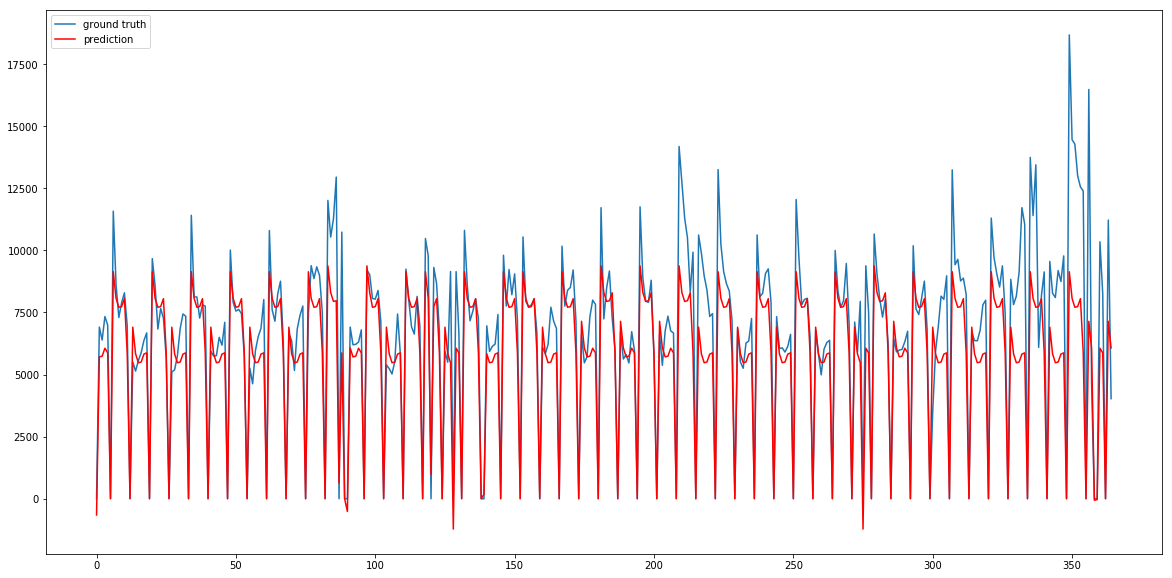

In [23]:
# Plot both series in the same plot and see how well we did.
plt.figure(figsize=(20, 10))  # Set figsize to increase size of figure
plt.plot(store_data.Sales.values[:365], label="ground truth")
plt.plot(y_store_predict[:365], c='r', label="prediction")
plt.legend()